In [99]:
#!/bin/env python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import datasets, linear_model, model_selection, preprocessing, feature_selection,metrics, ensemble
from sklearn import decomposition
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from lime import lime_tabular
from sklearn.feature_selection import RFE

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [100]:
housing_df = pd.read_csv("train.csv",header=0,sep=',', low_memory=False)
housing_df.head()
housing_df.describe().T
housing_df['Condition2'].value_counts()

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

In [101]:
housing_df.info(max_cols=None, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Step I - Structure Investigation

In [102]:
# let us check shape of the dataframe
housing_df.shape
housing_df.isnull().values.any()
housing_df.isnull().values.sum()

6965

In [103]:
# data types and their count
pd.value_counts(housing_df.dtypes)

object     43
int64      35
float64     3
dtype: int64

In [104]:
# let us check non-numerical columns
housing_df.describe(exclude="number")

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


<AxesSubplot: title={'center': 'Feature Unique values'}>

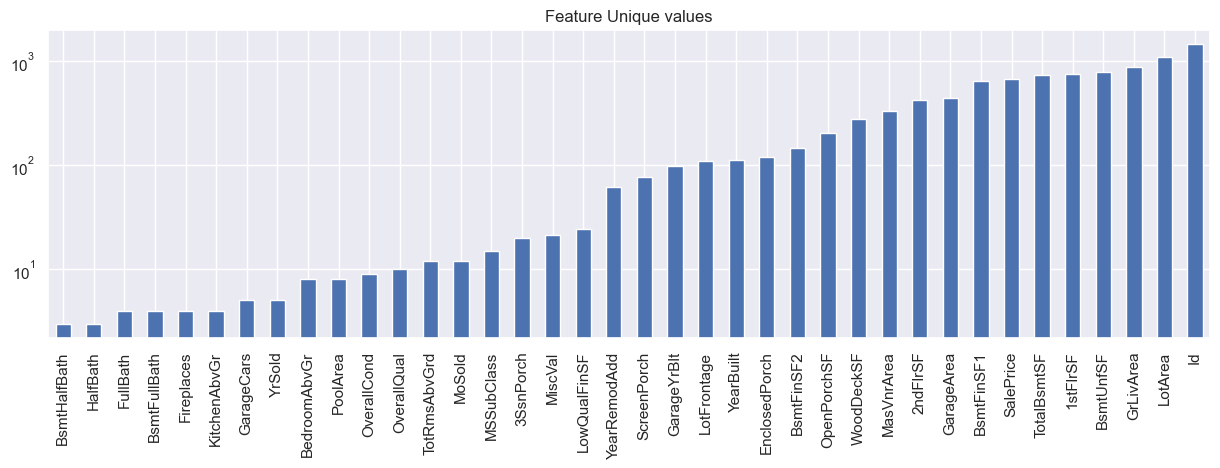

In [105]:
# now investigate numerical features, find how many unique values, binary(2 unique values),ordinal(3-10)
# or continous(>10 values)
unique_values = housing_df.select_dtypes(include="number").nunique().sort_values()

# plot with y-axis in log scale for visiblity
unique_values.plot.bar(logy=True, figsize=(15,4), title='Feature Unique values')
# Conclusion - BsmtHalfBath, HalfBath have less unique values.

# Step II - Data Quality Investigation

In [106]:
# Do we have Duplicate records ?
n_duplicates = housing_df.drop(labels=['Id'],axis=1).duplicated().sum()
print(n_duplicates)

# conclusion - no duplicates, unique IDs

0


In [107]:
# drop columns with only 1 or less type of value in addition to few more not adding value to analysis.
cols_valcounts = {}
col_valcounts = { cols:housing_df[cols].unique() for cols in housing_df.columns }
cols_to_drop = [ col for col,val in col_valcounts.items() if len(val) <=1 ]
print(len(cols_to_drop))

# Conclusion - nothing to drop

0


<AxesSubplot: >

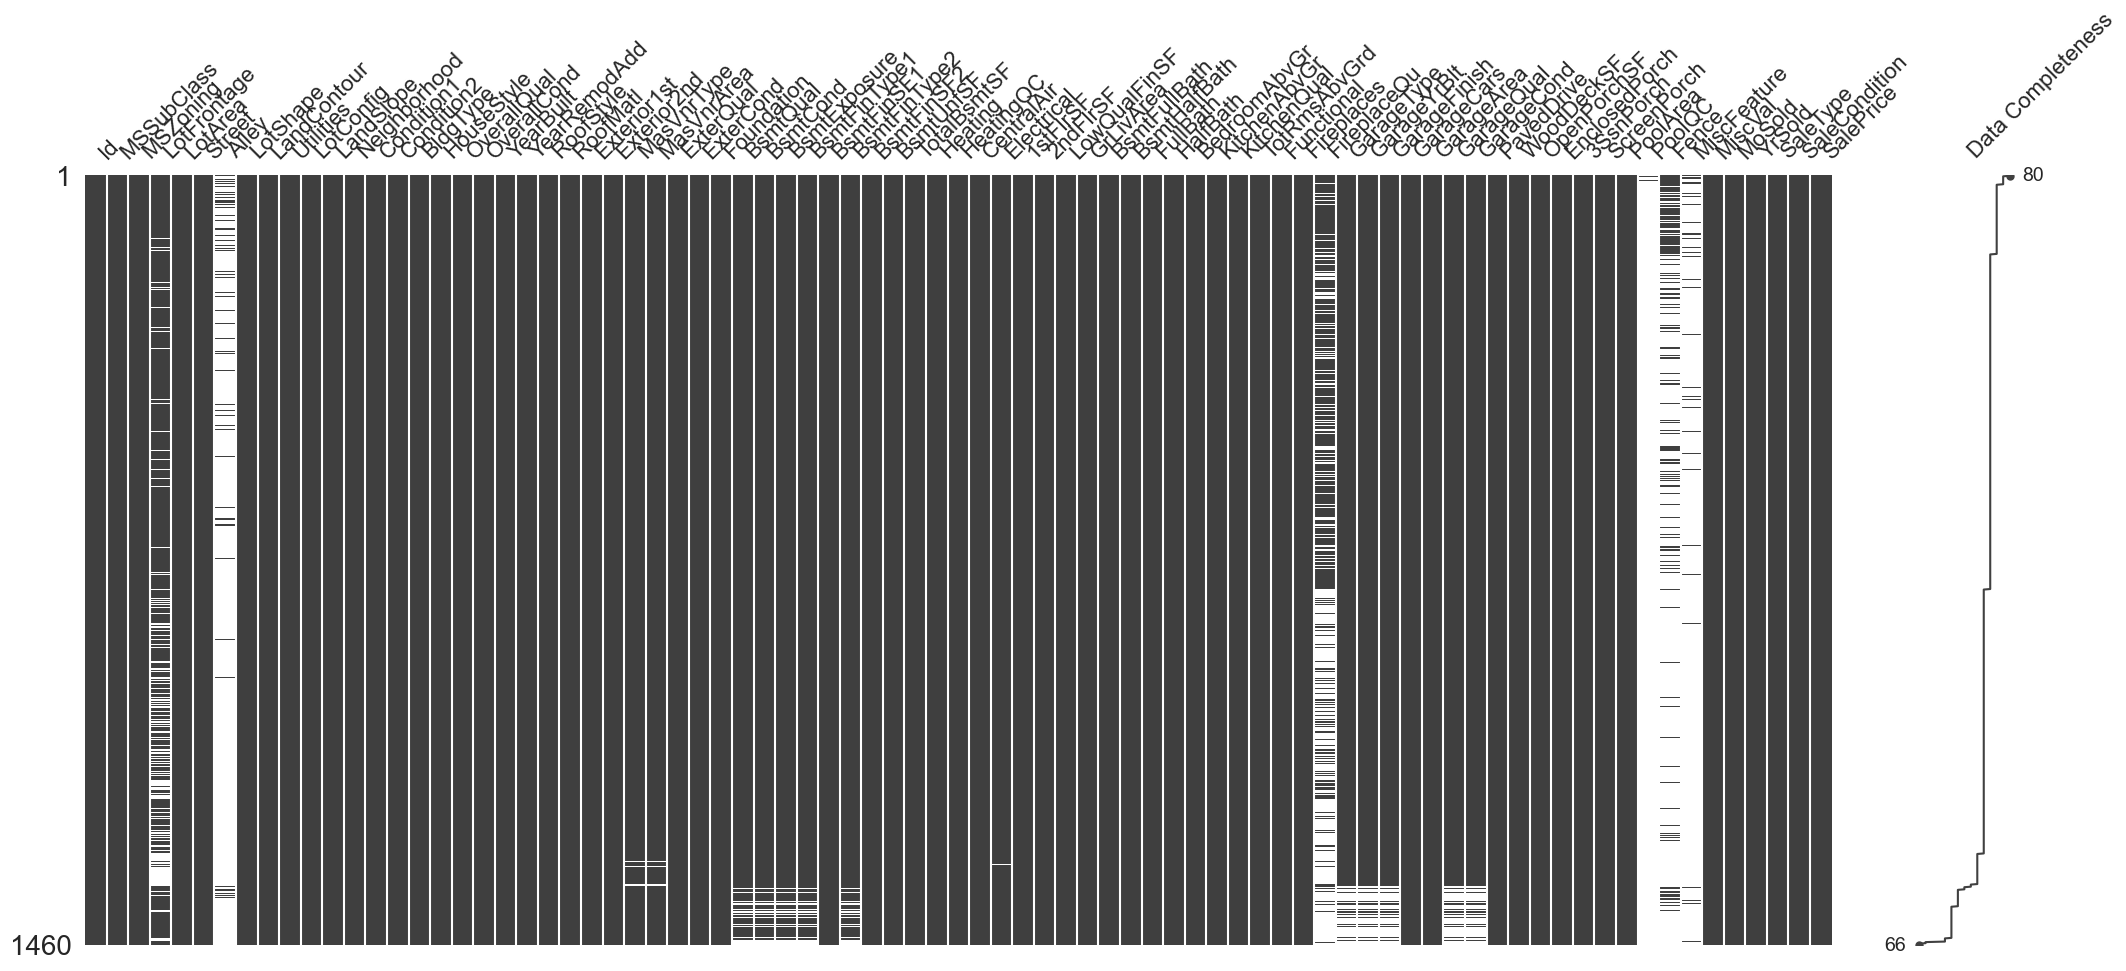

In [108]:
# Let us find any missing values across features for samples - horizontal investigation
import missingno as msno
msno.matrix(housing_df,labels=True,sort="descending")

# conclusion - there are no significant holes whre sample is missing data across multiple features
# there are some gaps in certian columns though like Alley, Fireplace 
# For These features NA has specific value like No Alley Access or No Fireplace, so we need to check it

In [109]:
# we will still attempt to drop any samples where >20% data is missing
housing_df = housing_df.dropna(thresh=housing_df.shape[1] * 0.80, axis=0).reset_index(drop=True)
housing_df.shape

# conclusion - no significant missing data

(1460, 81)

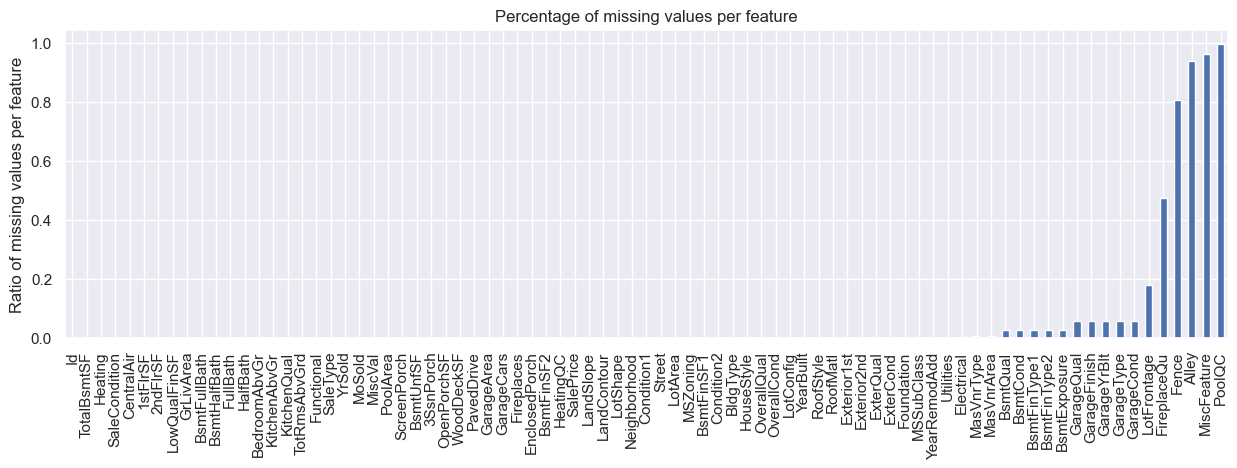

In [110]:
# Let us investigate features with missing values - vertical investigation
housing_df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

# Conclusion - Features 'LotFrontage' , FireplaceQu' ,'Fence' ,' Alley' , 'MiscFeature' and 'PoolQC' have 
# significant missing values
# their ratio of missing values is > 20%. However let us drop them carefully. 
# All these features are non-numerical except LotFrontage. So we can either drop lotfrontage or transform it with mean values.
# Also PoolQC has only 7 present value counts, MiscFeature has 50+ value counts present , so worth dropping. 

In [111]:
cols_to_drop =  ['PoolQC', 'MiscFeature', 'Street','Utilities']
housing_df = housing_df.drop(labels=cols_to_drop,axis=1)
housing_df.shape

housing_df["LotFrontage"] = housing_df["LotFrontage"].fillna(housing_df["LotFrontage"].mean())
housing_df.shape
housing_df['Condition2'].value_counts()

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

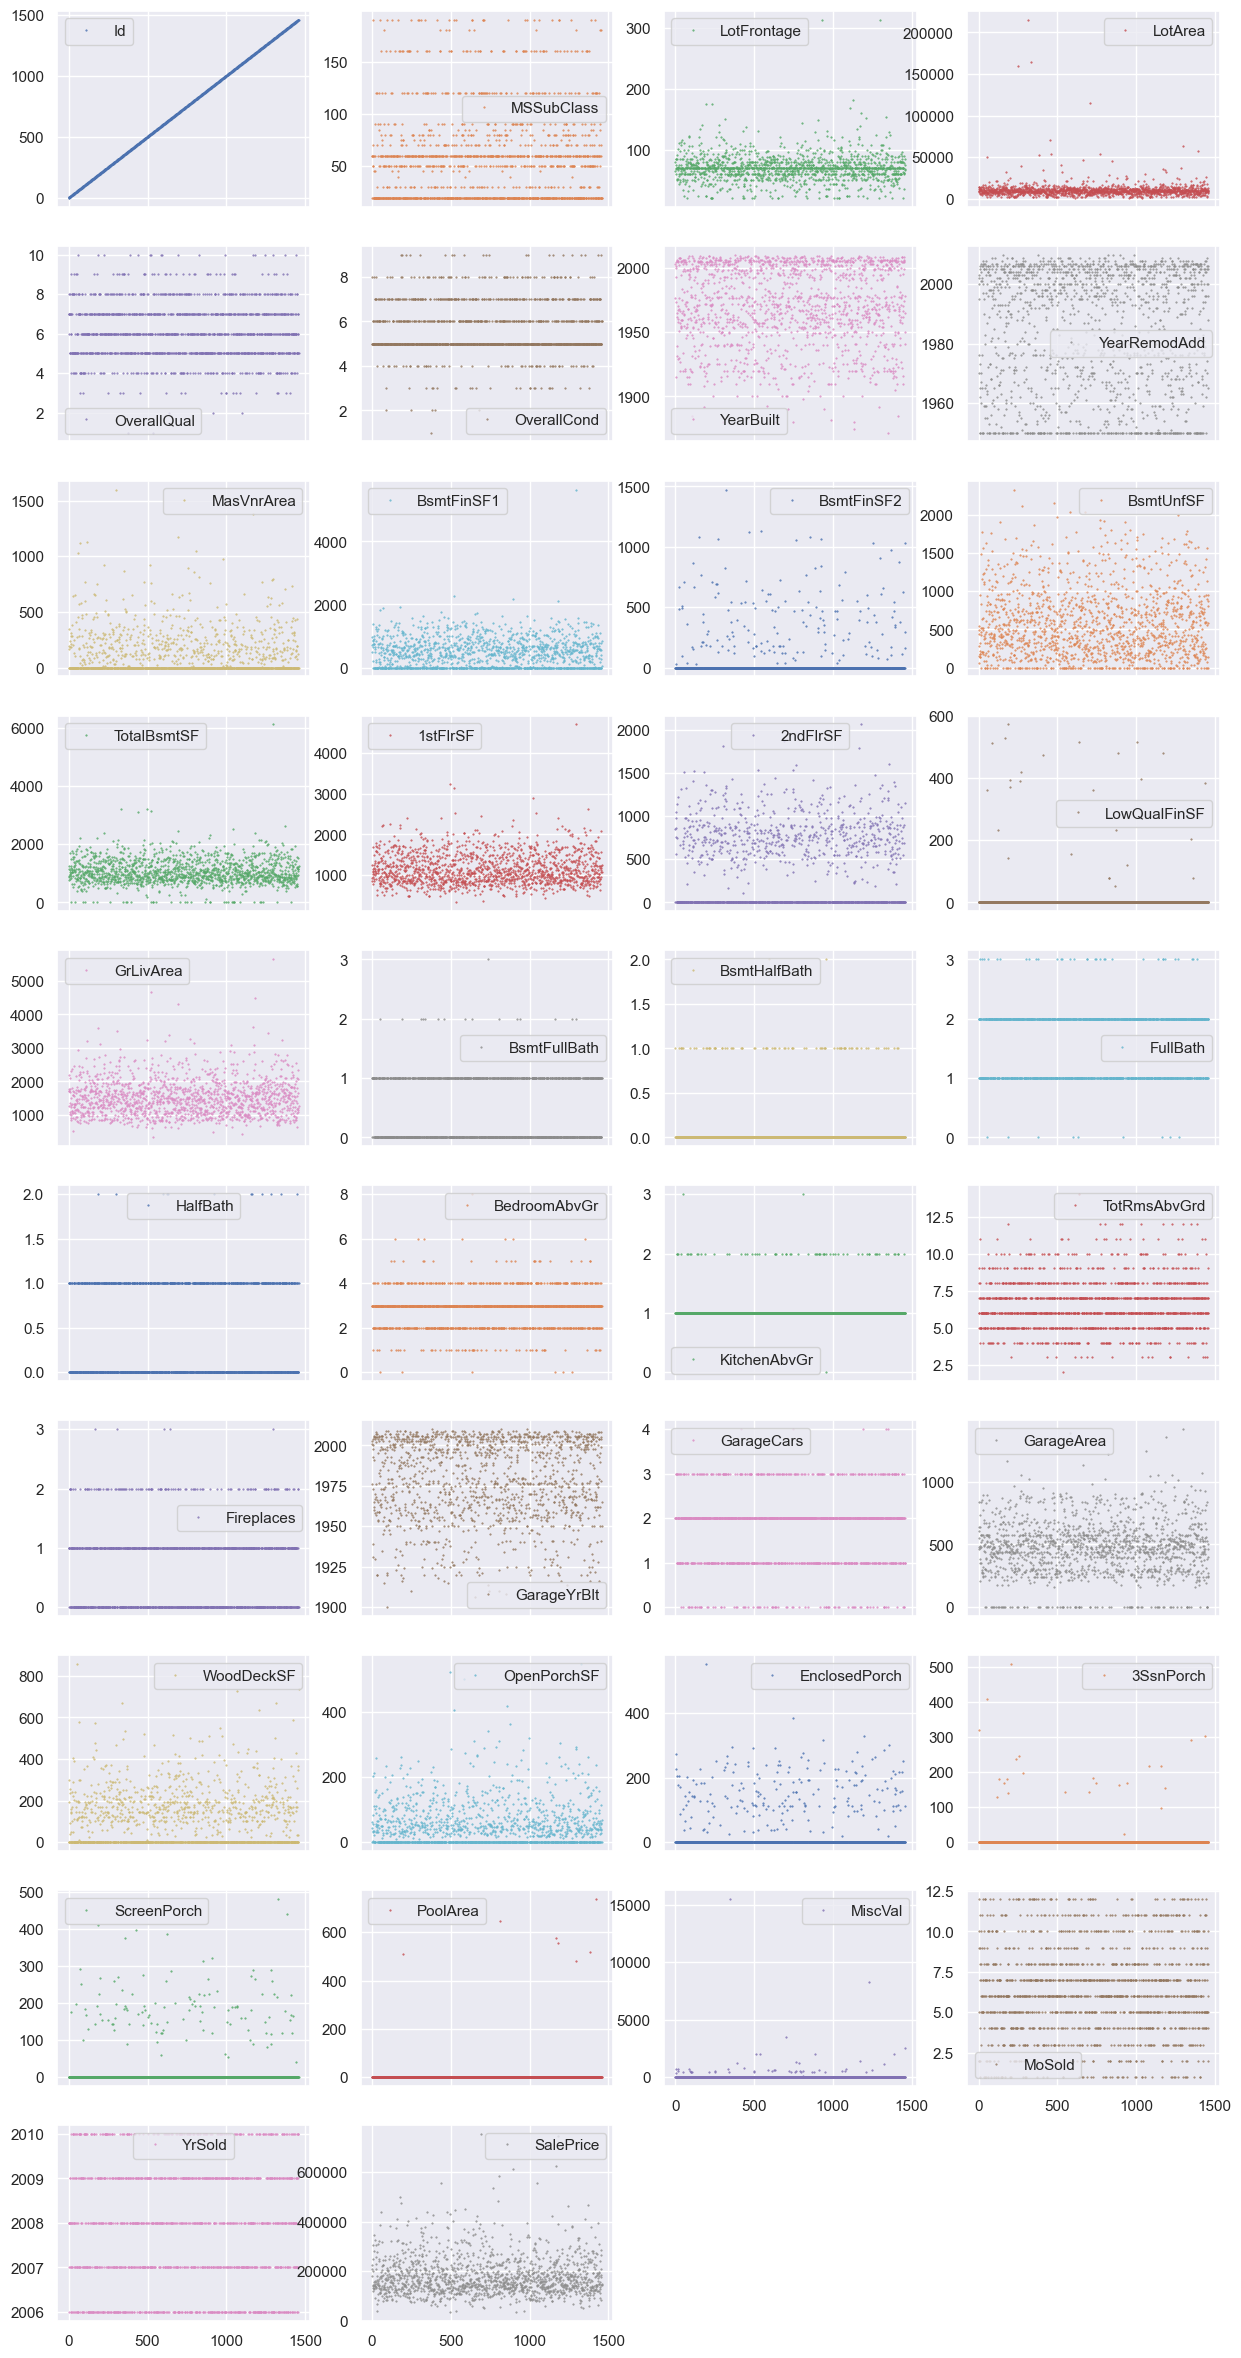

In [112]:
# Let us check all numerical features using dataframe plot. This will provide view on data value spread.

housing_df.plot(lw=0,
          marker=".",
          subplots=True,
          layout=(-1, 4),
          figsize=(15, 30),
          markersize=1)

# Conclusion - 'PoolArea' feature won't add much value. Majority of the samples have value '0', 
# so we can safely drop it. 'BsmtHalfBath' is also similar feature, but let us keep it for the time being.

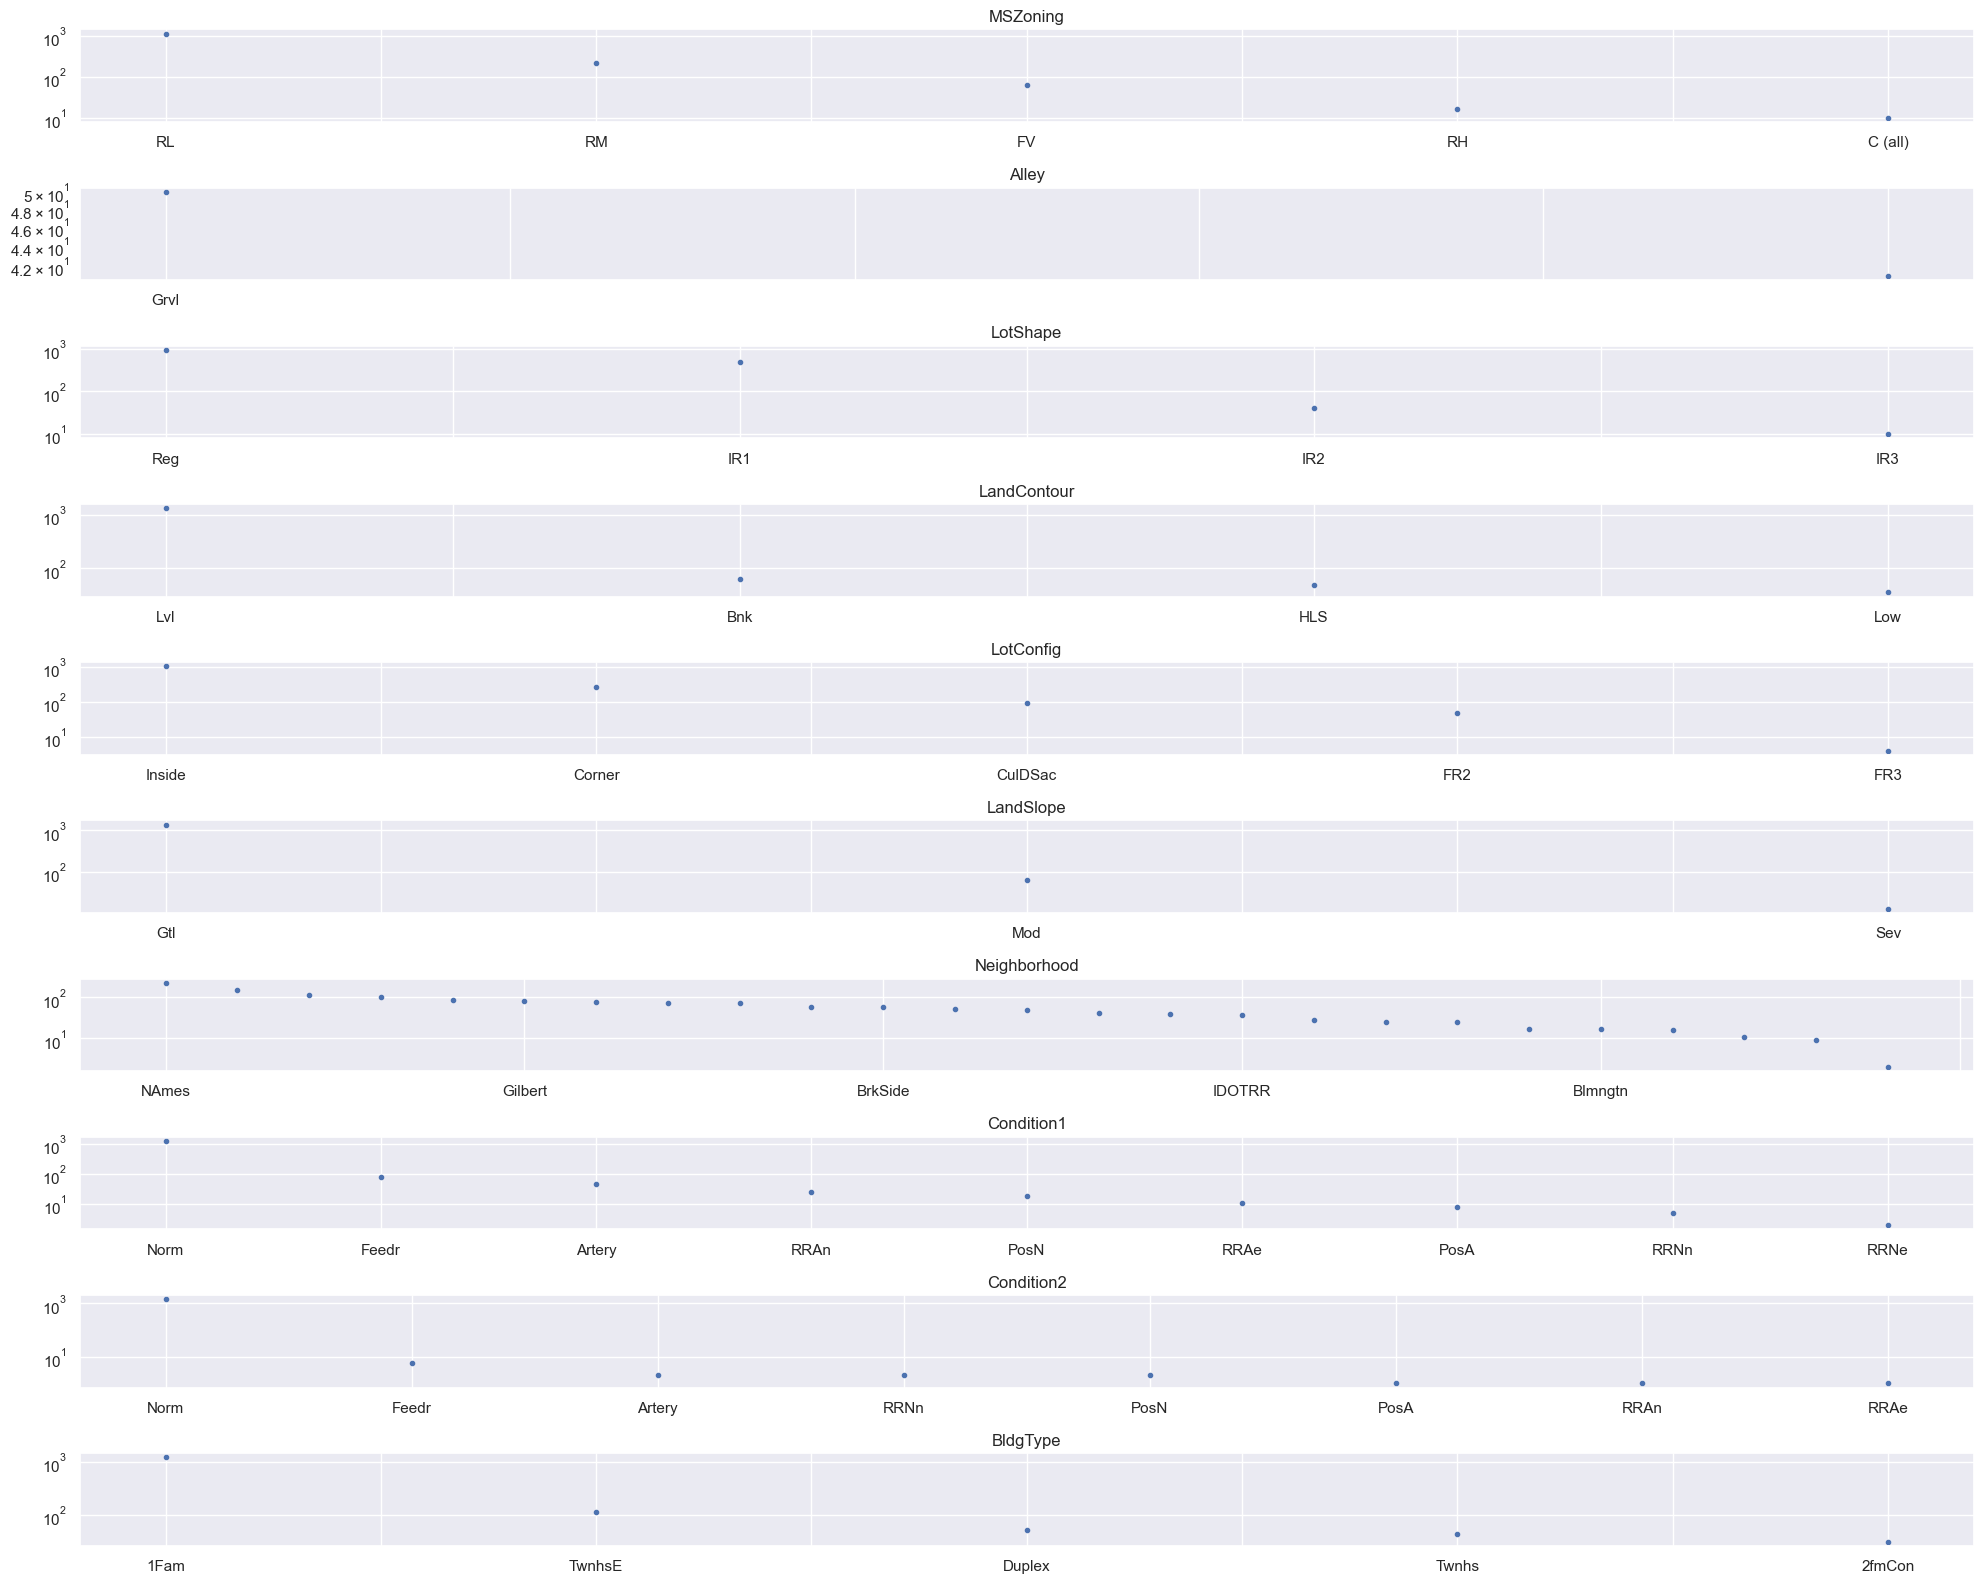

In [113]:
# Non-numerical feature investigation using plots. Instead of doing value_counts, let us check top 10
# check how value_counts are disrtibuted 

fig, axes = plt.subplots(ncols=1, nrows=10, figsize=(20, 16))
# Identify non-numerical features
df_non_numerical = housing_df.select_dtypes(include=["object"])
# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):
    # Selects one single feature and counts number of unique value
    df_non_numerical[col].value_counts().plot(
        # Plots this information in a figure with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax)
plt.tight_layout()

# Conclusion - 'Alley' feature is interesting. We didn't drop it earlier.
# It is mentioned here that NA here means no alley access, so we may not drop and change NaN as 'No Alley Access'


In [114]:
# in Addition to PoolArea,
cols_to_drop = ['PoolArea']
housing_df = housing_df.drop(labels=cols_to_drop,axis=1)
housing_df[['Alley']] = housing_df[['Alley']].fillna('No_Access')

housing_df.shape


(1460, 76)

# Step III - Content Investigation

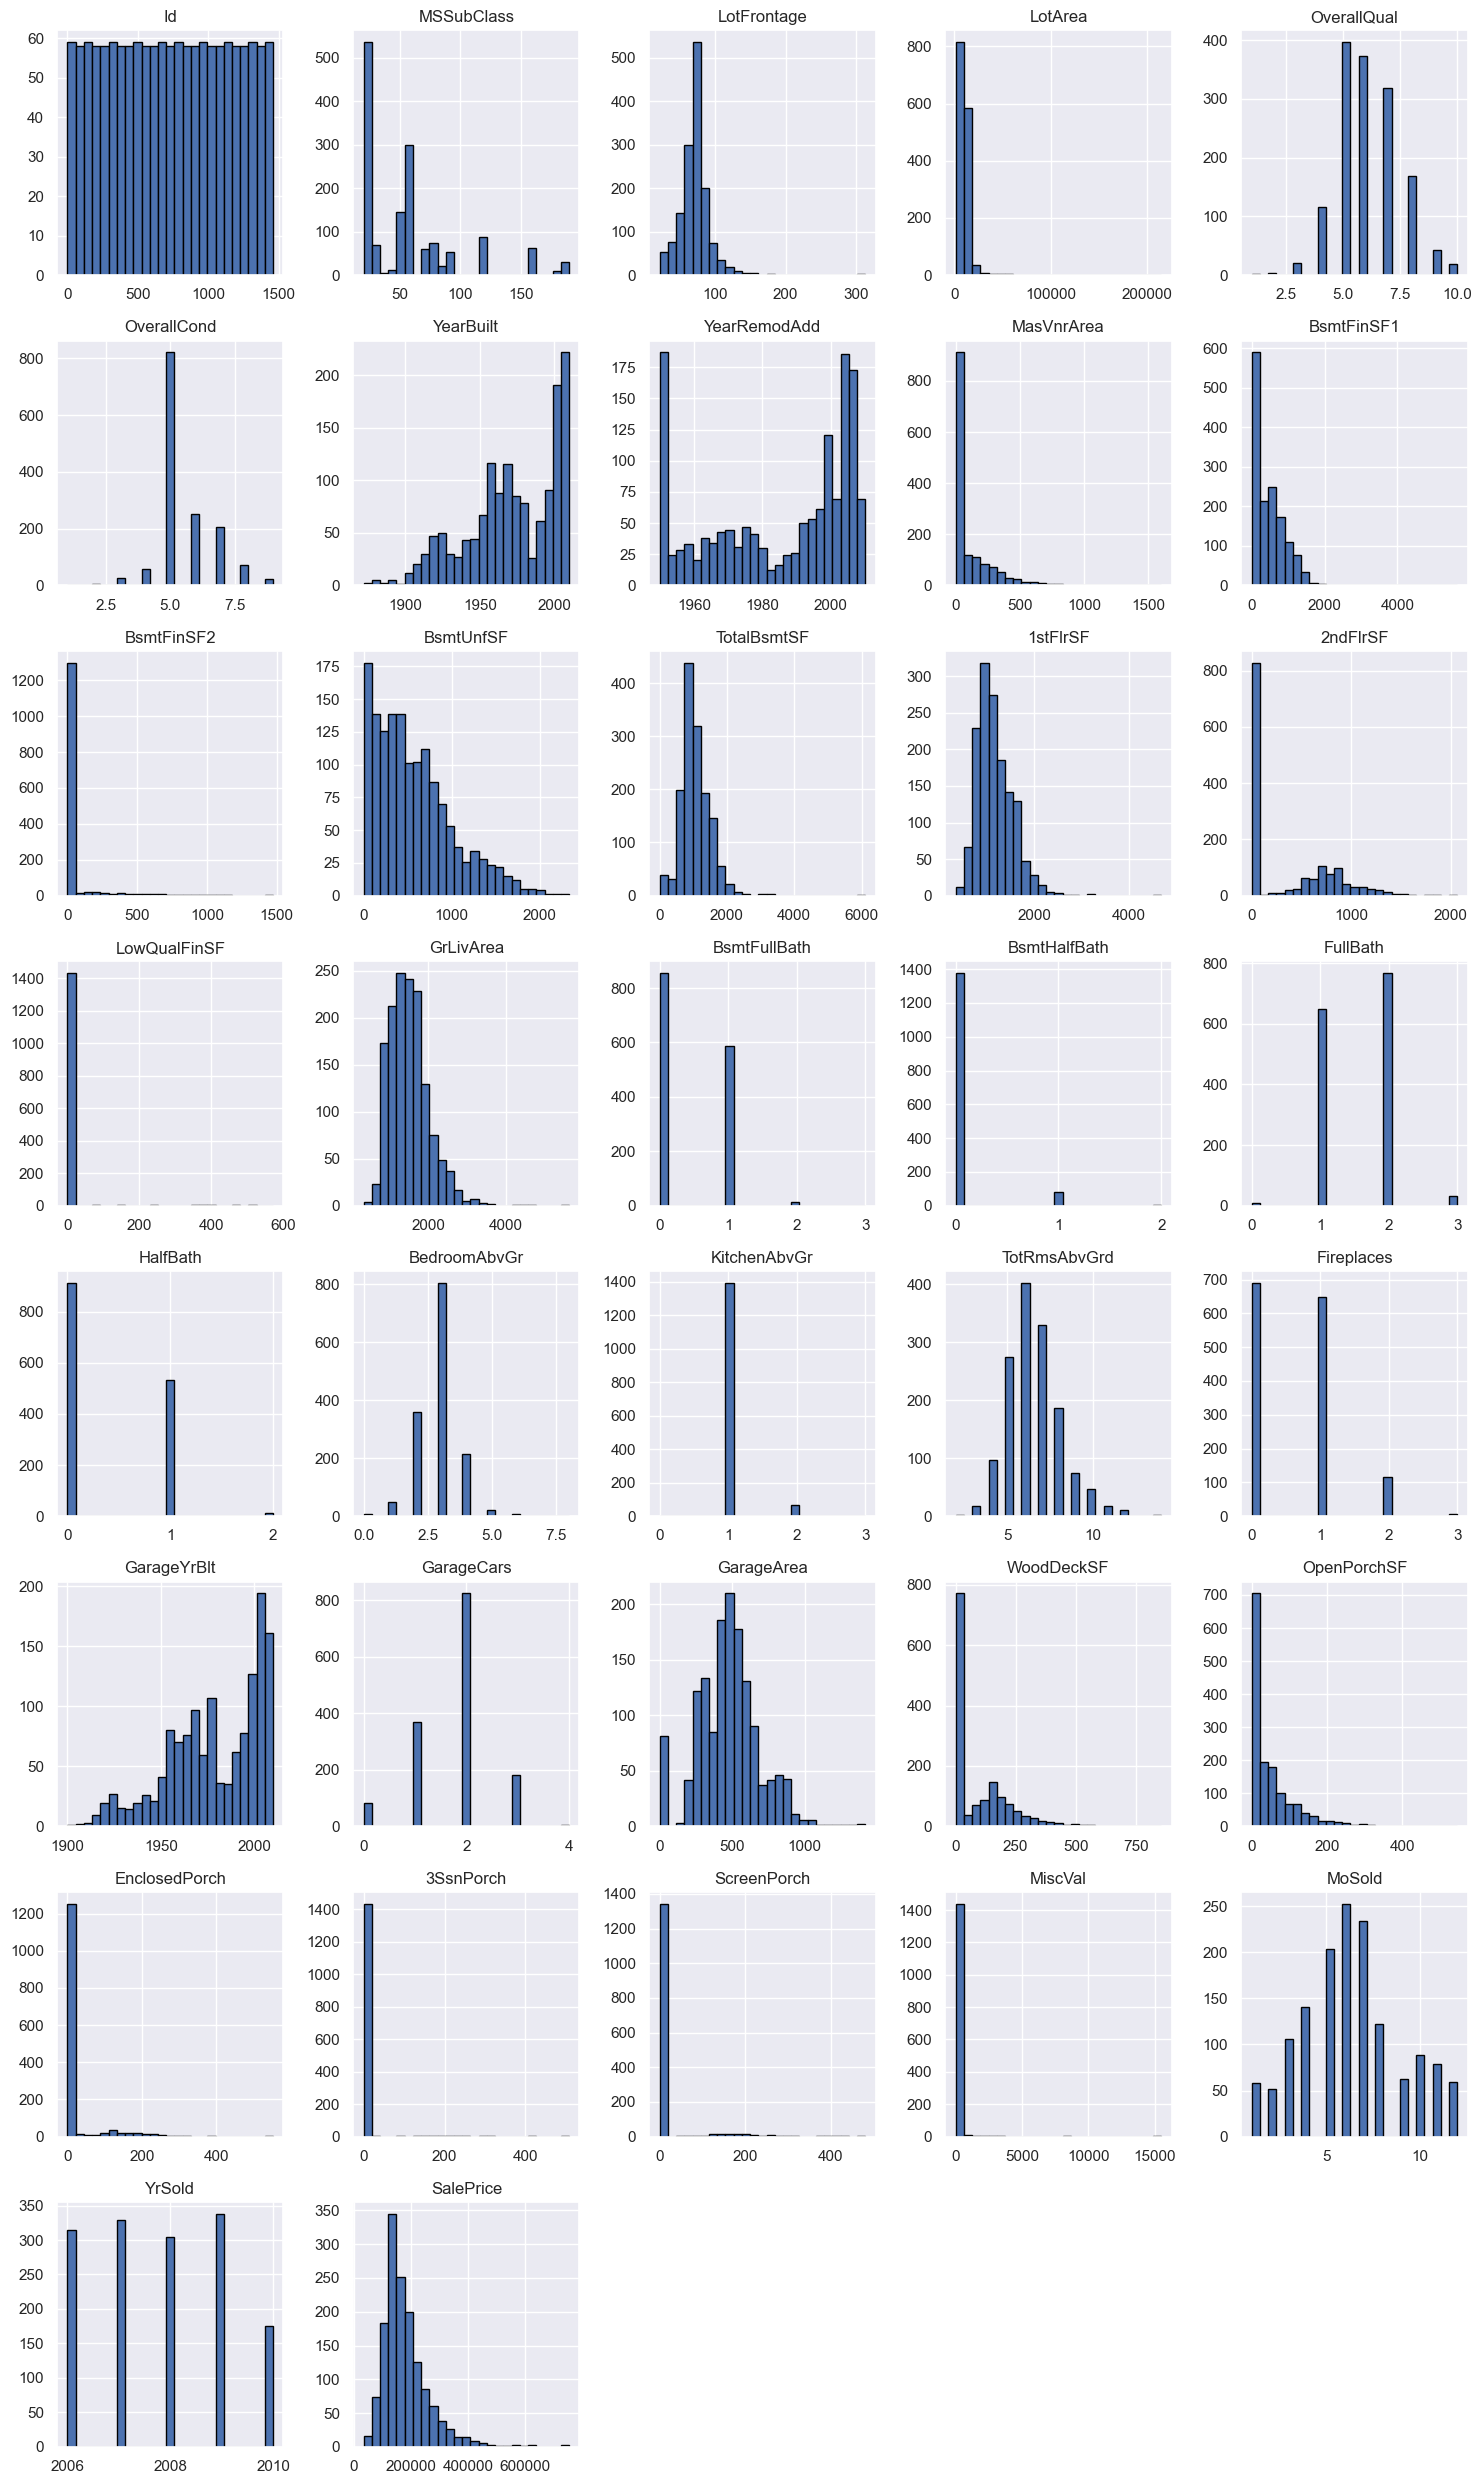

In [115]:
# Feature disrtibution using hist
housing_df.hist(bins=25,figsize=(15,25),layout=(-1,5),edgecolor='black')
plt.tight_layout()

HeatingQC     0.000685
Heating       0.000685
Foundation    0.000685
WoodDeckSF    0.000685
BsmtCond      0.000685
dtype: float64

<AxesSubplot: >

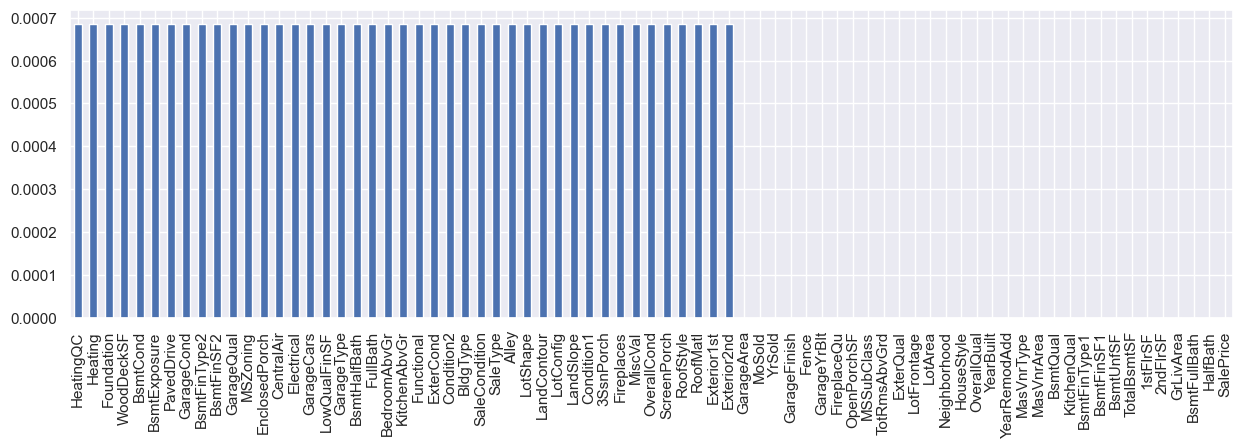

In [116]:
# Let us find most fequent entries in dataframe
most_freq_entry = housing_df.mode()
df_freq = housing_df.eq(most_freq_entry.values,axis=1)
df_freq = df_freq.drop(labels='Id',axis=1)
df_freq = df_freq.mean().sort_values(ascending=False)
display(df_freq.head())
df_freq.plot.bar(figsize=(15,4))

# Certain features are good to convert from categorical to numerical , some as ranges

In [117]:
# Let us find corelation of features, pair-plots and correlaton graphs would be useful
# For pairplot let us find columns which are continous i.e. those which have > 10 values

continous_cols = housing_df.select_dtypes(include="number").nunique() > 10
housing_df_continous = housing_df[continous_cols[continous_cols].index]
housing_df_continous.shape

housing_df.shape

(1460, 76)

In [118]:
#sns.pairplot(housing_df_continous,height=3)

/var/folders/t7/tq78zv4n6q59rwx2f5c0ktlh0000gn/T/ipykernel_9413/498487107.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = housing_df.corr(method="pearson")


<AxesSubplot: >

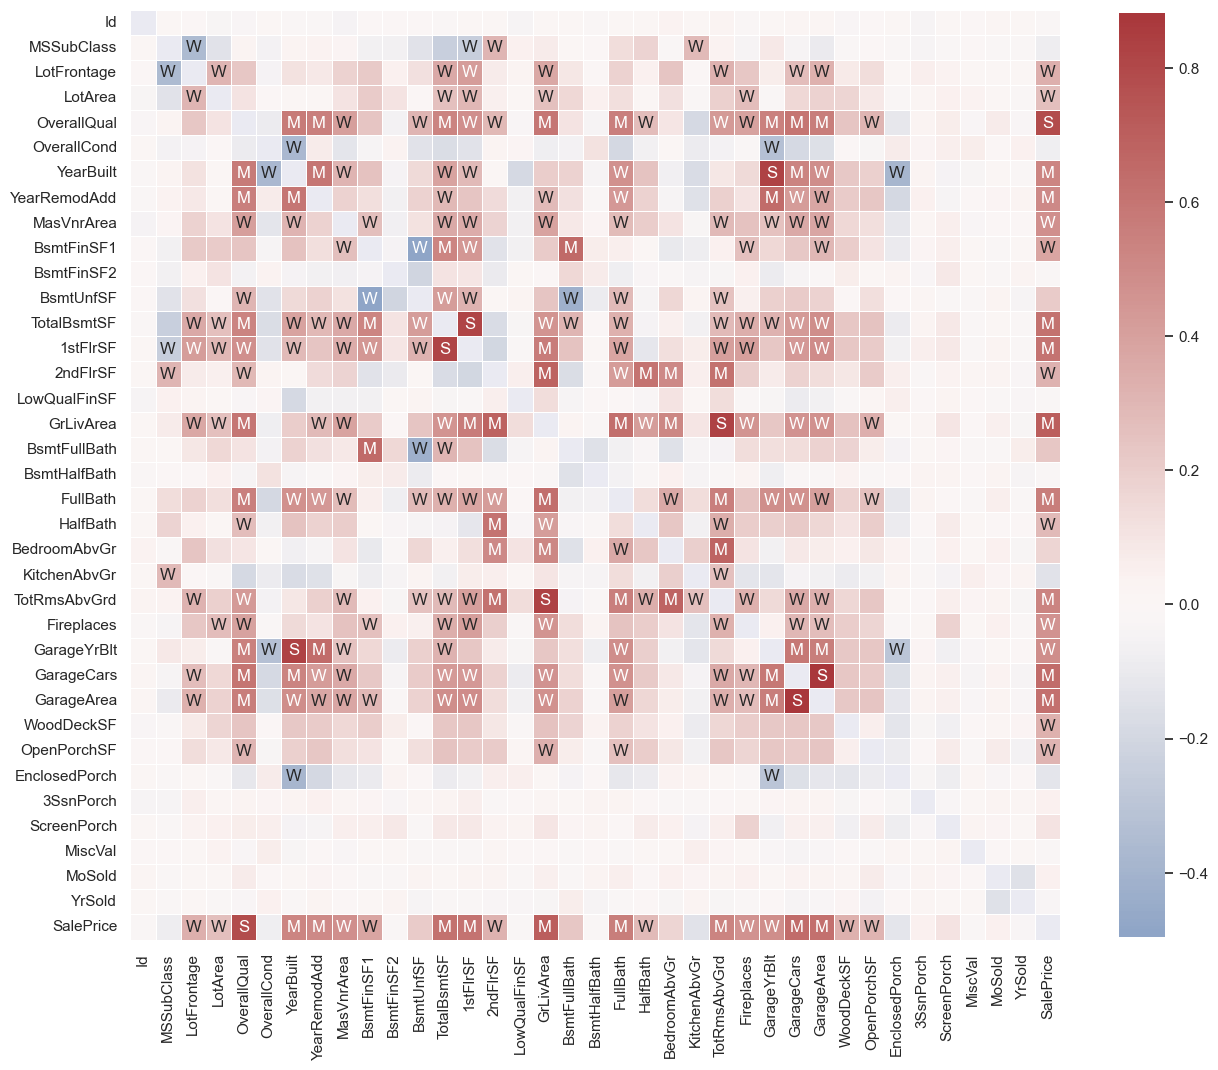

In [119]:
df_corr = housing_df.corr(method="pearson")

labels = np.where(np.abs(df_corr)>0.75,"S",np.where(np.abs(df_corr)>0.5, "M",
                                                   np.where(np.abs(df_corr)>0.25, "W", "")))

plt.figure(figsize=(15,15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True, center=0, annot=labels,
           fmt='', linewidths=0.5, cmap="vlag", cbar_kws={"shrink":0.8})


In [120]:
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")
#  Stack all correlations, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()
#  Showing the lowest and highest correlations in the correlation matrix
display(df_corr_stacked)
housing_df.shape
# Conclusion - No two features are highly negatively corelated. Max corelation is -0.495251
# Very high corelation between SalePrice adn GrLivArea and OverallQual
# Also 1stFlrSF and TotalBsmtSF are highly corelated
# GarageArea and GarageYrBlt are respectively corelated with GarageCars and GarageYrBlt, so we can drop these two
# Let us drop two redundent features - GarageYrBlt and GarageCars.

BsmtUnfSF      BsmtFinSF1      -0.495251
BsmtFullBath   BsmtUnfSF       -0.422900
EnclosedPorch  YearBuilt       -0.387268
YearBuilt      OverallCond     -0.375983
LotFrontage    MSSubClass      -0.357056
GarageYrBlt    OverallCond     -0.324297
EnclosedPorch  GarageYrBlt     -0.297003
1stFlrSF       MSSubClass      -0.251758
TotalBsmtSF    MSSubClass      -0.238518
BsmtUnfSF      BsmtFinSF2      -0.209294
2ndFlrSF       1stFlrSF        -0.202646
FullBath       OverallCond     -0.194149
EnclosedPorch  YearRemodAdd    -0.193919
GarageCars     OverallCond     -0.185758
KitchenAbvGr   OverallQual     -0.183882
LowQualFinSF   YearBuilt       -0.183784
KitchenAbvGr   YearBuilt       -0.174800
2ndFlrSF       TotalBsmtSF     -0.174512
TotalBsmtSF    OverallCond     -0.171098
BsmtFullBath   2ndFlrSF        -0.169494
GarageArea     OverallCond     -0.151521
EnclosedPorch  GarageCars      -0.151434
BedroomAbvGr   BsmtFullBath    -0.150673
KitchenAbvGr   YearRemodAdd    -0.149598
BsmtHalfBath   B

(1460, 76)

In [121]:
describe_df = housing_df_continous.describe().T

describe_df['IQR'] = describe_df['75%'] - describe_df['25%']

for col in describe_df.index:
    W1 = housing_df_continous[col].quantile(.25) - 1.5 * describe_df.loc[col,'IQR']
    W2 = housing_df_continous[col].quantile(.75) + 1.5 * describe_df.loc[col,'IQR']
    describe_df.loc[col,'Whisker1'] = W1
    describe_df.loc[col,'Whisker2'] = W2
    filt = (housing_df_continous[col] < W1 ) | (housing_df_continous[col] > W2)
    describe_df.loc[col,'max_outliers_value'] = round(housing_df_continous[filt][col].max(),2)
    describe_df.loc[col,'min_outliers_value'] = round(housing_df_continous[filt][col].min(),2)
    describe_df.loc[col,'no_of_outliers'] = len(housing_df_continous[filt][col])
describe_df['no_of_outliers'] = describe_df['no_of_outliers'].astype('int')
describe_df.sort_values(by=['no_of_outliers'])

,count,mean,std,min,25%,50%,75%,max,IQR,Whisker1,Whisker2,max_outliers_value,min_outliers_value,no_of_outliers
Id,1460.0,730.500000,421.610009,1.0,365.75,730.500000,1095.25,1460.0,729.50,-728.500,2189.500,NaN,NaN,0
GarageYrBlt,1379.0,1978.506164,24.689725,1900.0,1961.00,1980.000000,2002.00,2010.0,41.00,1899.500,2063.500,NaN,NaN,0
MoSold,1460.0,6.321918,2.703626,1.0,5.00,6.000000,8.00,12.0,3.00,0.500,12.500,NaN,NaN,0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.000000,2004.00,2010.0,37.00,1911.500,2059.500,NaN,NaN,0
2ndFlrSF,1460.0,346.992466,436.528436,0.0,0.00,0.000000,728.00,2065.0,728.00,-1092.000,1820.000,2065.0,1872.0,2
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.500000,712.25,5644.0,712.25,-1068.375,1780.625,5644.0,1810.0,7
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.000000,2000.00,2010.0,46.00,1885.000,2069.000,1882.0,1872.0,7
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.000000,1391.25,4692.0,509.25,118.125,2155.125,4692.0,2156.0,20
GarageArea,1460.0,472.980137,213.804841,0.0,334.50,480.000000,576.00,1418.0,241.50,-27.750,938.250,1418.0,947.0,21
3SsnPorch,1460.0,3.409589,29.317331,0.0,0.00,0.000000,0.00,508.0,0.00,0.000,0.000,508.0,23.0,24


<Figure size 800x500 with 0 Axes>

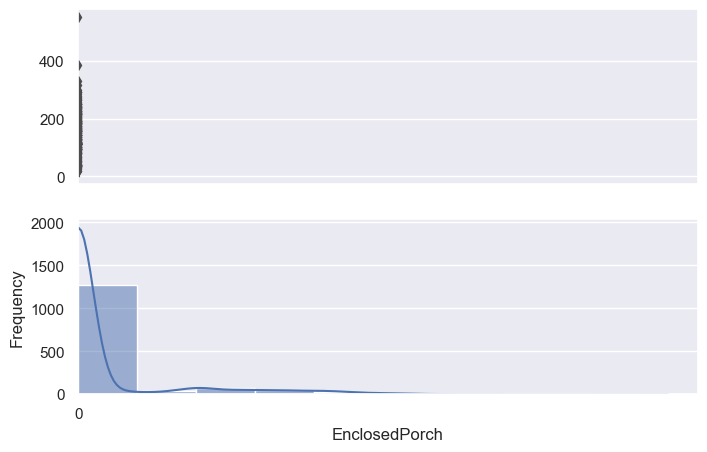

<Figure size 800x500 with 0 Axes>

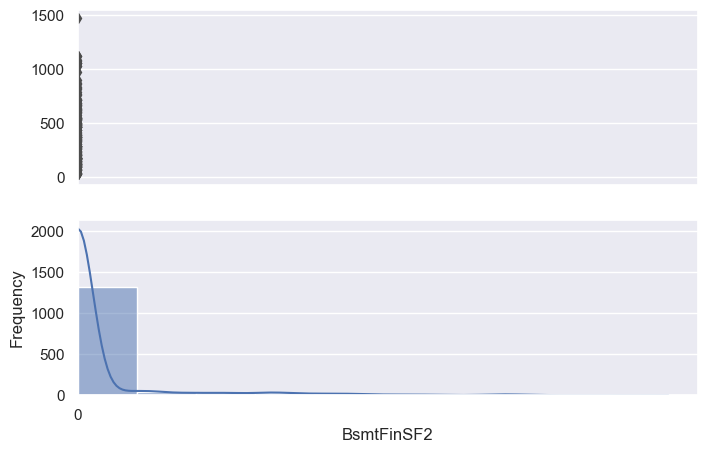

<Figure size 800x500 with 0 Axes>

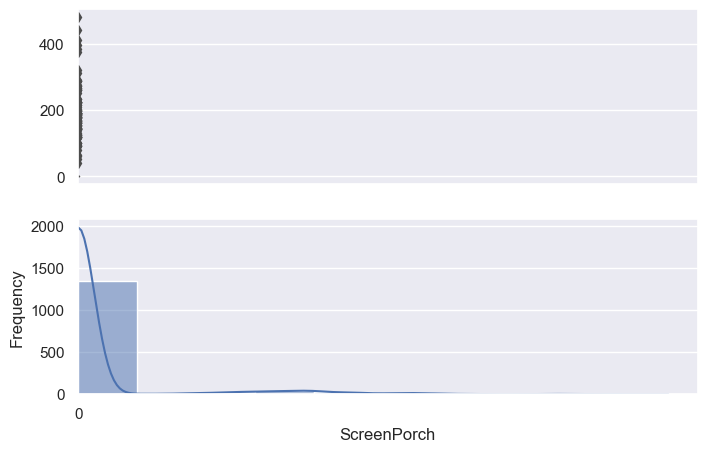

<Figure size 800x500 with 0 Axes>

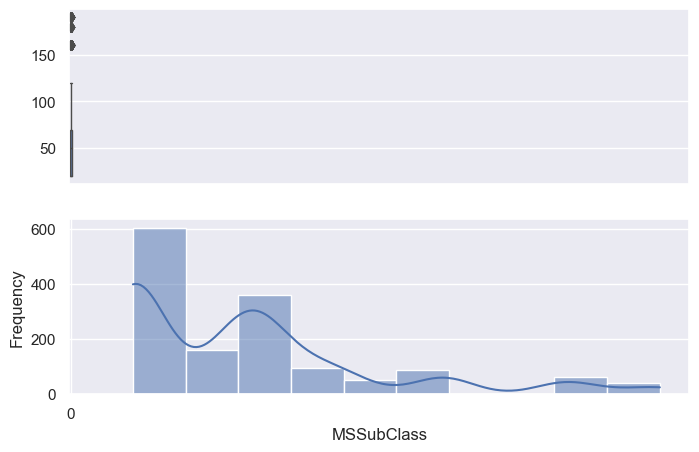

In [122]:
# Let us box plot last 4 features to visualise outliers where no_of_outliers are high from above cell
for cols in ['EnclosedPorch','BsmtFinSF2','ScreenPorch','MSSubClass']:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= cols,ylabel='Frequency')
    sns.boxplot(housing_df[cols], ax=ax_box , linewidth= 1.0)
    sns.histplot(housing_df[cols], ax=ax_hist , bins = 10,kde=True)
    
# Conclusion - no sigificant outliers in the data, just the frequency of some of the values is quite low.

In [123]:
cols_to_drop = ['GarageYrBlt', 'GarageCars' ]
housing_df = housing_df.drop(labels=cols_to_drop,axis=1)

In [124]:
# Now Let us think about NaN or Null values.
# Approach is to check NaN columns, if >50% of values are null for nancolumn, drop the column
# Otherwise , drop the subset of rows where NaN values exist.

# Let us take first shot at Nan columns

housing_df.isnull().values.sum()
nan_cols = housing_df.columns[housing_df.isnull().any()].tolist()
print(nan_cols)

['MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']


In [125]:
# Based on information provided 'NA' means "No Basement" or 'No Fireplace' etc. for features -BstQual, BsmtCond, BasmtExposure, BsmtFinType, 
# BsmtFinType2, FireqPlaceQu and GarageType and other Garage* variables
# so let us transform the values accordingly 

housing_df[['BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = housing_df[['BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].fillna('NA')
housing_df[['FireplaceQu']] = housing_df[['FireplaceQu']].fillna('NA')
housing_df[['Fence']] = housing_df[['Fence']].fillna('NA')
housing_df[['GarageType','GarageFinish', 'GarageQual', 'GarageCond']] = housing_df[['GarageType','GarageFinish', 'GarageQual', 'GarageCond']].fillna('NA')
housing_df[['MasVnrType']] = housing_df[['MasVnrType']].fillna('none')
housing_df[['MasVnrArea']] = housing_df[['MasVnrArea']].fillna(0)
housing_df.shape

(1460, 74)

In [126]:
# Check if data is now clean
nan_cols = housing_df.columns[housing_df.isnull().any()].tolist()
print(nan_cols)

['Electrical']


In [127]:
for cols in nan_cols:
    print(housing_df[cols].isnull().values.sum())

1


In [128]:
# Now let us drop NAN values from remaining value , so we get clean data
housing_df = housing_df.dropna(subset=['Electrical'])

In [129]:
housing_df.shape

(1459, 74)

In [130]:
nan_cols = housing_df.columns[housing_df.isnull().any()].tolist()
print(nan_cols)

[]


In [131]:
# Now Let us convert all Categorical features into Dummy Encoding for Discrete values
categorical_columns=['MSZoning','Alley','Fence','LotShape','LandContour','LotConfig','LandSlope',
                                               'Neighborhood','Condition1','Condition2','BldgType', 
                                                'HouseStyle','RoofStyle','RoofMatl','Exterior1st',
                                                'Exterior2nd','MasVnrType','Foundation','Heating','CentralAir',
                                                'Electrical','GarageType','PavedDrive','SaleType','SaleCondition']


housing_df = pd.get_dummies(housing_df, columns=categorical_columns)

In [132]:
# Let us inspect value counts and drop insignificant columns now where >80% value 
# is 0 i.e. feature is not present significantly
categorical_columns=['MSZoning','Alley','Fence','LotShape','LandContour','LotConfig','LandSlope',
                                               'Neighborhood','Condition1','Condition2','BldgType', 
                                                'HouseStyle','RoofStyle','RoofMatl','Exterior1st',
                                                'Exterior2nd','MasVnrType','Foundation','Heating','CentralAir',
                                                'Electrical','GarageType','PavedDrive','SaleType','SaleCondition']
count = 0
cols_to_drop = []
for cols in categorical_columns:
    
    colnames = housing_df.columns[[x.startswith(cols) for x in housing_df.columns]]
    for col in colnames:
        count += 1
        #print(col)
        #print(housing_df[col].value_counts(normalize=True))
        if(housing_df[col].value_counts(normalize=True)[0] > 0.8):
            cols_to_drop.append(col)
print(cols_to_drop)
print(len(cols_to_drop))
print(count)

['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RM', 'Alley_Grvl', 'Alley_Pave', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'LotShape_IR2', 'LotShape_IR3', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_PosA',

In [133]:
housing_df = housing_df.drop(labels=cols_to_drop,axis=1)
housing_df.shape

(1459, 78)

In [134]:
housing_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice,MSZoning_RL,Alley_No_Access,Fence_NA,LotShape_IR1,LotShape_Reg,LandContour_Lvl,LotConfig_Inside,LandSlope_Gtl,Condition1_Norm,Condition2_Norm,BldgType_1Fam,HouseStyle_1Story,HouseStyle_2Story,RoofStyle_Gable,RoofMatl_CompShg,Exterior1st_VinylSd,Exterior2nd_VinylSd,MasVnrType_BrkFace,MasVnrType_None,Foundation_CBlock,Foundation_PConc,Heating_GasA,CentralAir_Y,Electrical_SBrkr,GarageType_Attchd,GarageType_Detchd,PavedDrive_Y,SaleType_WD,SaleCondition_Normal
0,1,60,65.0,8450,7,5,2003,2003,196.0,Gd,TA,Gd,TA,No,GLQ,706,Unf,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,RFn,548,TA,TA,0,61,0,0,0,0,2,2008,208500,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1
1,2,20,80.0,9600,6,8,1976,1976,0.0,TA,TA,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,RFn,460,TA,TA,298,0,0,0,0,0,5,2007,181500,1,1,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,0,1,1,0,1,1,1,1,0,1,1,1
2,3,60,68.0,11250,7,5,2001,2002,162.0,Gd,TA,Gd,TA,Mn,GLQ,486,Unf,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,RFn,608,TA,TA,0,42,0,0,0,0,9,2008,223500,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1
3,4,70,60.0,9550,7,5,1915,1970,0.0,TA,TA,TA,Gd,No,ALQ,216,Unf,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Unf,642,TA,TA,0,35,272,0,0,0,2,2006,140000,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,1,0,0,1,1,1,0,1,1,1,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,Gd,TA,Gd,TA,Av,GLQ,655,Unf,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,RFn,836,TA,TA,192,84,0,0,0,0,12,2008,250000,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1


In [135]:
cols_to_drop = ['Id']
housing_df = housing_df.drop(labels=cols_to_drop,axis=1)
housing_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice,MSZoning_RL,Alley_No_Access,Fence_NA,LotShape_IR1,LotShape_Reg,LandContour_Lvl,LotConfig_Inside,LandSlope_Gtl,Condition1_Norm,Condition2_Norm,BldgType_1Fam,HouseStyle_1Story,HouseStyle_2Story,RoofStyle_Gable,RoofMatl_CompShg,Exterior1st_VinylSd,Exterior2nd_VinylSd,MasVnrType_BrkFace,MasVnrType_None,Foundation_CBlock,Foundation_PConc,Heating_GasA,CentralAir_Y,Electrical_SBrkr,GarageType_Attchd,GarageType_Detchd,PavedDrive_Y,SaleType_WD,SaleCondition_Normal
0,60,65.0,8450,7,5,2003,2003,196.0,Gd,TA,Gd,TA,No,GLQ,706,Unf,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,RFn,548,TA,TA,0,61,0,0,0,0,2,2008,208500,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1
1,20,80.0,9600,6,8,1976,1976,0.0,TA,TA,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,RFn,460,TA,TA,298,0,0,0,0,0,5,2007,181500,1,1,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,0,1,1,0,1,1,1,1,0,1,1,1
2,60,68.0,11250,7,5,2001,2002,162.0,Gd,TA,Gd,TA,Mn,GLQ,486,Unf,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,RFn,608,TA,TA,0,42,0,0,0,0,9,2008,223500,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1
3,70,60.0,9550,7,5,1915,1970,0.0,TA,TA,TA,Gd,No,ALQ,216,Unf,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Unf,642,TA,TA,0,35,272,0,0,0,2,2006,140000,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,1,0,0,1,1,1,0,1,1,1,0
4,60,84.0,14260,8,5,2000,2000,350.0,Gd,TA,Gd,TA,Av,GLQ,655,Unf,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,RFn,836,TA,TA,192,84,0,0,0,0,12,2008,250000,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1


In [136]:
# Now Let us convert all Categorical features into Ordinal numbers where Dummy encoding is not appropriate
# These scale mappers are based on documentation provided

qscale_mapper = { "NA":0, "Po":1, "No": 1, "Fa":2, "Mn":2,"TA":3,"Av":3,"Gd":4,"Ex":5 }
for cols in ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','HeatingQC','KitchenQual','FireplaceQu',
            'GarageQual','GarageCond']:
    housing_df[cols] = housing_df[cols].replace(qscale_mapper)
    
bscale_mapper = { "NA":0, "Unf":1, "LwQ": 2, "RFn": 2, "Rec":3, "Fin": 3, "BLQ": 4,"ALQ": 5,"GLQ": 6}
for cols in ['BsmtFinType1','BsmtFinType2','GarageFinish']:
    housing_df[cols] = housing_df[cols].replace(bscale_mapper)
    
fscale_mapper = { "Sal":0,"Sev":1,"Maj2":2,"Maj1":3,"Mod":4,"Min2":5, "Min1":6, "Typ":7 }
for cols in ['Functional']:
    housing_df[cols] = housing_df[cols].replace(fscale_mapper)
    

# Completion of Data Clean-up, ready for Regression

# Regression

In [137]:
# Let us prep X and y

# Create X and y from housing_df. Y i.e. target variable is saleprice.


df_train, df_test = model_selection.train_test_split(housing_df, test_size=0.3,random_state=17)

print(df_train.head())
print(df_test.head())
print(df_train.shape,df_test.shape)

X_train = df_train.drop(columns='SalePrice')
Xcols = X_train.columns
y_train = df_train['SalePrice']

X_test = df_test.drop(columns='SalePrice')
y_test = df_test['SalePrice']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(Xcols)
#X = housing_df.drop(columns='SalePrice').values
#y = housing_df['SalePrice'].values

#print(X,y)
## split data
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.3,random_state=17)

#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
1386          60    80.000000    16692            7            5       1978   
1231          90    70.000000     7728            5            6       1962   
817           20    70.049958    13265            8            5       2002   
859           60    70.049958    11029            6            7       1968   
76            20    70.049958     8475            4            7       1956   

      YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  \
1386          1978       184.0          3          3         4         3   
1231          1962       120.0          3          3         3         3   
817           2002       148.0          4          3         4         3   
859           1984       220.0          3          3         3         3   
76            1956         0.0          3          3         3         3   

      BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinS

In [138]:
#scaler = MinMaxScaler()
scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test = scaler.transform(y_test.values.reshape(-1,1))

In [139]:
# Linear regression, predictions , RSS, R2scores, MSE, RMSE
lr = linear_model.LinearRegression()

In [140]:
y_train
print(Xcols)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_RL',
       'Alley_No_Access', 'Fence_NA', 'LotShape_IR1', 'LotShape_Reg',
       'LandContour_Lvl', 'LotConfig_Inside', 'LandSlope_Gtl',
       'Condition1_Norm', 'Condition2_Norm', 'BldgType_1Fam',
       'HouseStyle_1Story', 'HouseStyle_2Story', 'RoofStyle_Ga

In [141]:
lr.fit(X_train,y_train)
train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)
print("For Linear Regression train and test scores are {} {}".format(train_score_lr,test_score_lr))

For Linear Regression train and test scores are 0.8829392821847056 0.6381647659144857


In [142]:

y_pred = lr.predict(X_test)
rfe = RFE(lr, n_features_to_select=25)             # running RFE to extract for 25 
rfe.fit(X_train, y_train)

train_score_rfe = rfe.score(X_train, y_train)
test_score_rfe = rfe.score(X_test, y_test)
print("For Linear Regression train and test scores are {} {}".format(train_score_rfe,test_score_rfe))

For Linear Regression train and test scores are 0.8707574481267346 0.6378600842262259


In [143]:
list(zip(Xcols,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 35),
 ('LotFrontage', False, 20),
 ('LotArea', False, 37),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', False, 33),
 ('MasVnrArea', True, 1),
 ('ExterQual', True, 1),
 ('ExterCond', False, 16),
 ('BsmtQual', True, 1),
 ('BsmtCond', True, 1),
 ('BsmtExposure', False, 17),
 ('BsmtFinType1', False, 23),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinType2', False, 42),
 ('BsmtFinSF2', False, 50),
 ('BsmtUnfSF', False, 9),
 ('TotalBsmtSF', True, 1),
 ('HeatingQC', False, 43),
 ('1stFlrSF', False, 7),
 ('2ndFlrSF', False, 2),
 ('LowQualFinSF', False, 51),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 32),
 ('BsmtHalfBath', False, 21),
 ('FullBath', False, 38),
 ('HalfBath', False, 19),
 ('BedroomAbvGr', True, 1),
 ('KitchenAbvGr', True, 1),
 ('KitchenQual', True, 1),
 ('TotRmsAbvGrd', True, 1),
 ('Functional', False, 8),
 ('Fireplaces', False, 3),
 ('FireplaceQu', False, 4),
 ('GarageFinish', False, 45),
 ('GarageArea', Tru

In [144]:
print(lr.intercept_)
print(lr.coef_)

[-0.19398791]
[[-9.32279884e-03  3.62990061e-02  1.18286691e-02  2.65395102e-01
   8.88971972e-02  1.26766319e-01 -1.58912809e-02  9.15150622e-02
   1.26246259e-01 -4.40315217e-02  5.92135449e-02 -1.29678277e-01
   3.71127438e-02 -2.21563035e-02  1.34492251e-01 -6.57655655e-04
   3.52645622e-05 -3.36445369e-02  1.60395589e-01  2.52738348e-03
   7.21838849e-02  2.20025599e-01 -3.13821788e-05  2.98345010e-01
   1.11281296e-02 -2.09456412e-02 -9.22119847e-03  4.29845773e-02
  -8.43789001e-02 -1.46916582e-01  9.83054940e-02  5.93336213e-02
   6.12782919e-02  1.14084216e-01 -1.01494061e-01  1.67183207e-03
   9.40873826e-02  6.39970037e-02 -1.23076067e-01  2.98315380e-02
  -8.18504253e-03 -4.26156432e-05  3.86977952e-04  2.95993462e-04
   3.67267787e-06 -1.84395738e-02 -3.50485930e-03  4.08773055e-02
   5.12109292e-02 -1.76367982e-02 -7.94129339e-02 -9.93171291e-02
   4.64383137e-02 -1.82849382e-02 -1.03595819e-01  1.28557293e-01
   4.61911781e-01  6.43766702e-02  9.95997696e-02 -4.40595474e

In [145]:
rss = np.sum(np.square(y_test - y_pred))
print(rss)
mse = mean_squared_error(y_test, y_pred)
print(mse)
rmse = mse **0.5
print(rmse)


124.82372711488827
0.2849856783444938
0.5338404989737044


In [146]:
y_res = y_test - y_pred

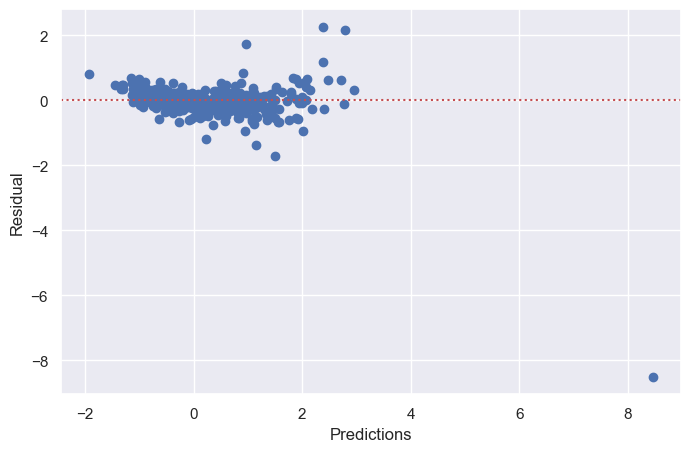

In [148]:
plt.scatter(y_pred, y_res)
plt.axhline(y=0,color='r',linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

/var/folders/t7/tq78zv4n6q59rwx2f5c0ktlh0000gn/T/ipykernel_9413/2800443369.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(y_res,kde=True)


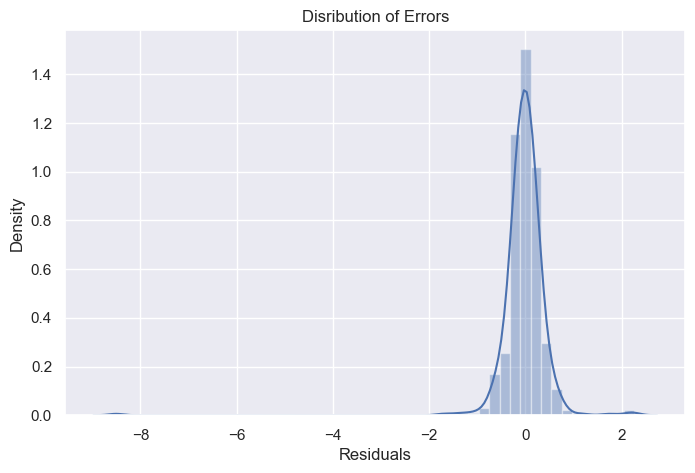

In [149]:
p = sns.distplot(y_res,kde=True)
p = plt.title("Disribution of Errors")
plt.xlabel("Residuals")
plt.show()

In [150]:
# p-Value

feature_names = Xcols
selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=10).fit(X_train,y_train)
pvalue_selected_features = feature_names[selector.get_support()]

/Users/dhananjayjoshi/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [151]:
## Ridge regularization

rlr = linear_model.Ridge(alpha=20.0, fit_intercept=True)
rlr.fit(X_train,y_train)
selector = feature_selection.SelectFromModel(estimator=rlr,max_features=10)
regularization_selected_features = feature_names[selector.get_support()]

train_score_rlr = rlr.score(X_train, y_train)
test_score_rlr = rlr.score(X_test, y_test)
print("For Ridge Regression train and test scores are {} {}".format(train_score_rlr,test_score_rlr))


For Ridge Regression train and test scores are 0.8806512716136158 0.6656349759071234


<AxesSubplot: xlabel='selection', ylabel='features'>

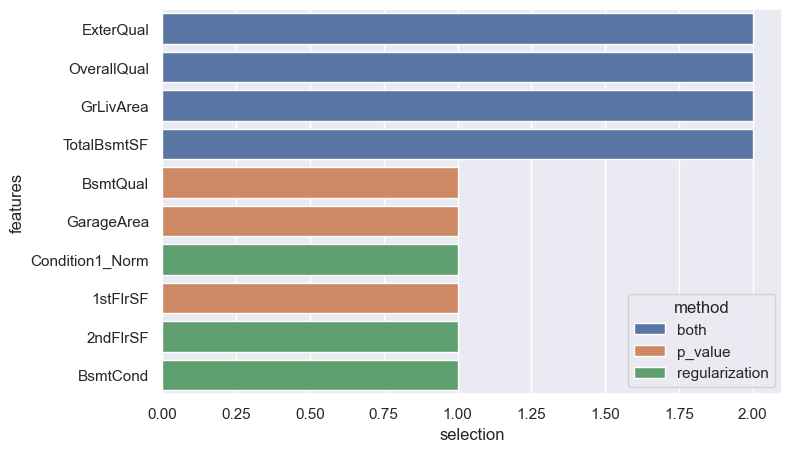

In [152]:
housing_features = pd.DataFrame({"features":feature_names})

# populate against every feature string and number value - feature selected due to pvalue
housing_features["p_value"] = housing_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
housing_features["p_num"] = housing_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)

# populate against every feature string and number value - feature selected due to regularization
housing_features["regularization"] = housing_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
housing_features["r_num"] = housing_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)

# populate against every feature string and number value - feature selected due to both pvalue and regularization
housing_features["method"] = housing_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
housing_features["selection"] = housing_features["p_num"] + housing_features["r_num"]
housing_features["method"] = housing_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
# Let us plot top-10
sns.barplot(y="features", x="selection", hue="method", data=housing_features.sort_values("selection", ascending=False)[0:10], dodge=False)

In [153]:
print(housing_features)

                features  p_value  p_num  regularization  r_num  \
0             MSSubClass               0                      0   
1            LotFrontage               0                      0   
2                LotArea               0                      0   
3            OverallQual  p_value      1  regularization      1   
4            OverallCond               0                      0   
5              YearBuilt               0  regularization      1   
6           YearRemodAdd               0                      0   
7             MasVnrArea               0                      0   
8              ExterQual  p_value      1  regularization      1   
9              ExterCond               0                      0   
10              BsmtQual  p_value      1                      0   
11              BsmtCond               0  regularization      1   
12          BsmtExposure               0                      0   
13          BsmtFinType1               0                      

In [154]:
housing_features[housing_features['selection'] == 2 ]

,features,p_value,p_num,regularization,r_num,method,selection
3,OverallQual,p_value,1,regularization,1,both,2
8,ExterQual,p_value,1,regularization,1,both,2
18,TotalBsmtSF,p_value,1,regularization,1,both,2
23,GrLivArea,p_value,1,regularization,1,both,2


<AxesSubplot: xlabel='selection', ylabel='features'>

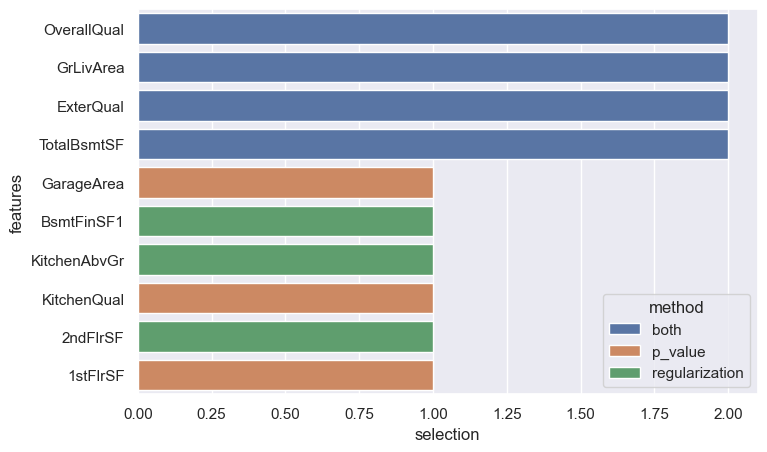

In [155]:
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=3.0, fit_intercept=True), 
                                 max_features=10).fit(X_train,y_train)
regularization_selected_features = feature_names[selector.get_support()]

housing_features = pd.DataFrame({"features":feature_names})

# populate against every feature string and number value - feature selected due to pvalue
housing_features["p_value"] = housing_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
housing_features["p_num"] = housing_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)

# populate against every feature string and number value - feature selected due to regularization
housing_features["regularization"] = housing_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
housing_features["r_num"] = housing_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)

# populate against every feature string and number value - feature selected due to both pvalue and regularization
housing_features["method"] = housing_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
housing_features["selection"] = housing_features["p_num"] + housing_features["r_num"]
housing_features["method"] = housing_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
# Let us plot top-10
sns.barplot(y="features", x="selection", hue="method", data=housing_features.sort_values("selection", ascending=False)[0:10], dodge=False)


In [156]:
housing_features[housing_features['selection'] == 2 ]

,features,p_value,p_num,regularization,r_num,method,selection
3,OverallQual,p_value,1,regularization,1,both,2
8,ExterQual,p_value,1,regularization,1,both,2
18,TotalBsmtSF,p_value,1,regularization,1,both,2
23,GrLivArea,p_value,1,regularization,1,both,2


In [157]:
y_pred = rlr.predict(X_test)
rss = np.sum(np.square(y_test - y_pred))
print(rss)
mse = mean_squared_error(y_test, y_pred)
print(mse)
rmse = mse **0.5
print(rmse)

115.34722048176337
0.26334981845151456
0.5131762060457544


<AxesSubplot: xlabel='selection', ylabel='features'>

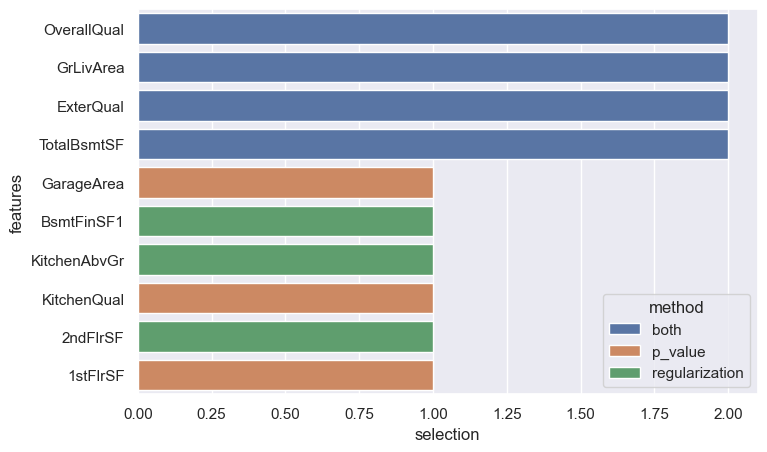

In [158]:

selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=5.0, fit_intercept=True), 
                                 max_features=10).fit(X_train,y_train)
regularization_selected_features = feature_names[selector.get_support()]

housing_features = pd.DataFrame({"features":feature_names})

# populate against every feature string and number value - feature selected due to pvalue
housing_features["p_value"] = housing_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
housing_features["p_num"] = housing_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)

# populate against every feature string and number value - feature selected due to regularization
housing_features["regularization"] = housing_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
housing_features["r_num"] = housing_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)

# populate against every feature string and number value - feature selected due to both pvalue and regularization
housing_features["method"] = housing_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
housing_features["selection"] = housing_features["p_num"] + housing_features["r_num"]
housing_features["method"] = housing_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
# Let us plot top-10
sns.barplot(y="features", x="selection", hue="method", data=housing_features.sort_values("selection", ascending=False)[0:10], dodge=False)


In [159]:
housing_features[housing_features['selection'] == 2 ]

,features,p_value,p_num,regularization,r_num,method,selection
3,OverallQual,p_value,1,regularization,1,both,2
8,ExterQual,p_value,1,regularization,1,both,2
18,TotalBsmtSF,p_value,1,regularization,1,both,2
23,GrLivArea,p_value,1,regularization,1,both,2


In [160]:
## Lasso regularization

rlr = linear_model.Lasso(alpha=1.0, fit_intercept=False)
rlr.fit(X_train,y_train)
selector = feature_selection.SelectFromModel(estimator=rlr,max_features=10)
regularization_selected_features = feature_names[selector.get_support()]

train_score_rlr = rlr.score(X_train, y_train)
test_score_rlr = rlr.score(X_test, y_test)
print("For Lasso Regression train and test scores are {} {}".format(train_score_rlr,test_score_rlr))

For Lasso Regression train and test scores are -0.010929087249575975 -0.022625193846506075


<AxesSubplot: xlabel='selection', ylabel='features'>

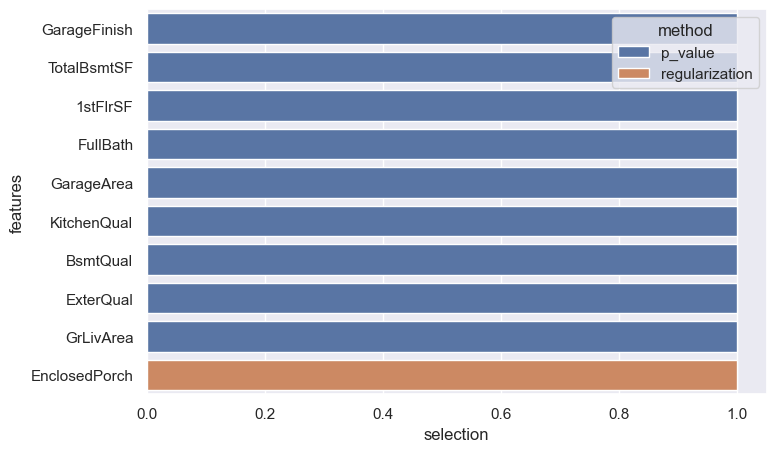

In [161]:
regularization_selected_features = feature_names[selector.get_support()]

housing_features = pd.DataFrame({"features":feature_names})

# populate against every feature string and number value - feature selected due to pvalue
housing_features["p_value"] = housing_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
housing_features["p_num"] = housing_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)

# populate against every feature string and number value - feature selected due to regularization
housing_features["regularization"] = housing_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
housing_features["r_num"] = housing_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)

# populate against every feature string and number value - feature selected due to both pvalue and regularization
housing_features["method"] = housing_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
housing_features["selection"] = housing_features["p_num"] + housing_features["r_num"]
housing_features["method"] = housing_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
# Let us plot top-10
sns.barplot(y="features", x="selection", hue="method", data=housing_features.sort_values("selection", ascending=False)[0:10], dodge=False)


In [162]:
y_pred = rlr.predict(X_test)
rss = np.sum(np.square(y_test - y_pred))
print(rss)
mse = mean_squared_error(y_test, y_pred)
print(mse)
rmse = mse **0.5
print(rmse)

159420.72189762592
0.8054316083868163
0.897458415965228
